<a href="https://colab.research.google.com/github/LCaravaggio/politext/blob/main/Toda_la_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import ast

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
# Se lee la base original
base=pd.read_csv('/content/drive/MyDrive/par_esp_interventions_l1_l13.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [34]:
base.party.unique()

array(['UCD, AP-PDP, CP', 'PSOE', 'UCD', 'PNV', 'PDC, CiU',
       'AP, CD, AP-PDP, CP, PP', 'PCE', 'PSA', 'UPC', 'PSC-PSOE', 'ERC',
       'EE', 'PSE-PSOE, PSE-EE', 'PSUC-PCE', 'UCD, CDS', 'PSdeG-PSOE',
       'CAIC, PAR, AP-PDP', 'UN', 'UCD, UPN, AP-PDP, CP, UPN-PP',
       'PSA, PA', 'UCD, CC-UCD', 'CD', 'UCD, CP', 'PSE-PSOE', 'PCE, IU',
       'UCD, CP, PP', 'Independiente, CD, AP-PDP, CP', nan, 'UCD, PP',
       'CC-UCD, CiU', 'CiU', 'UCD, CD, AP-PDP, CP, PP', 'CD, AP-PDP',
       'PDC, PSC-PSOE', 'UCD, CC', 'UCD, AP-PDP, CP, PP', 'US-PSP, PSOE',
       'UCD, AP-PDP', 'AP, CD, AP-PDP, CP', 'UCD, PSOE (PAD), PSOE',
       'UC-DCC, CC-UCD', 'UCD, PSOE (PAD)', 'PSP, PSOE', 'DC, CiU',
       'CC-UCD', 'UCD, PSOE', 'PSUC-PCE, PSC-PSOE[1]<U+200B>',
       'PCE, PSOE', 'PSOE, IU', 'AL, UCD', 'AP, CD, AP-PDP',
       'PSC-PSOE[1]<U+200B>', 'PSC-PSOE (PSA)', 'CiU, PP',
       'PNV[3]<U+200B>, EA', 'UCD, CDS, PP', 'AP-PDP, CP',
       'AP-PDP, CP, PP', 'AP-PDP', 'UCD, AP-PDP, CP, CDS', 'UCD

In [40]:
base['partido']=base['party']
base.party.replace(dict.fromkeys(['PSC-PSOE', 'PSE-PSOE, PSE-EE', 'PSE-EE', 'PSE-PSOE', 'PDC, PSC-PSOE', 'US-PSP, PSOE', 'UCD, PSOE (PAD), PSOE', 
                    'PSP, PSOE', 'UCD, PSOE', 'UCD, PSOE', 'PSUC-PCE, PSC-PSOE[1]<U+200B>', 'PCE, PSOE', 'PSOE, IU', 'PSOE, IU', 'PSC-PSOE[1]<U+200B>', 'PSC-PSOE (PSA)', 
                    'UEC (PSUC), IC, PSC-PSOE', 'IU, PSdeG-PSOE', 'EE, PSE-EE (PSOE)', 'PSE-EE (PSOE)', 'IU, PDNI, PSOE', 'IU, PSOE', 'PSUC-PCE, PSC-PSOE', 'PSOE (Los Verdes)', 
                    'UPyD, PSOE', 'PSOE, PSOE-NCa', "PSOE, C's"],['PSOE']), inplace=True)
base.party.replace(dict.fromkeys(['AP, CD, AP-PDP, CP, PP', 'UCD, UPN, AP-PDP, CP, UPN-PP', 'UCD, CP, PP', 'UCD, PP', 'UCD, CD, AP-PDP, CP, PP', 'CD, AP-PDP', 'UCD, AP-PDP, CP', 'UCD, AP-PDP, CP, PP'
                    'AP-PDP-UV', 'CAIC, AP-PDP, PAR', 'AP, AP-PDP, CP, PP', 'UPN-AP-PDP', 'AP-PDP-UV, UV', 'CP, PP', 'CP, PP-CG','UCD, CP, UPN-PP', 'PP-CG, PP', 'UPN-PP'
                    'PP, PP-PAR', 'PP-PAR, PP', 'PP, PP-EU', 'UV, PP', 'PP-PAR', 'PP, PP-FORO', 'AP-PDP, PP', 'UPN-PP, PP', 'PP-EU', 'PP-EU, PP', 'PP, FORO','AP-PDP-UV, CP'
                    'UCD, CDS, PP', 'AP-PDP, CP', 'AP-PDP, CP, PP', 'AP-PDP', 'UCD, AP-PDP, CP, CDS'],['PP']), inplace=True)

In [41]:
base.party.unique()

array(['PP', 'PSOE', 'UCD', 'PNV', 'PDC, CiU', 'PCE', 'PSA', 'UPC', 'ERC',
       'EE', 'PSUC-PCE', 'UCD, CDS', 'PSdeG-PSOE', 'CAIC, PAR, AP-PDP',
       'UN', 'PSA, PA', 'UCD, CC-UCD', 'CD', 'UCD, CP', 'PCE, IU',
       'Independiente, CD, AP-PDP, CP', nan, 'CC-UCD, CiU', 'CiU',
       'UCD, CC', 'UCD, AP-PDP, CP, PP', 'UCD, AP-PDP',
       'AP, CD, AP-PDP, CP', 'UC-DCC, CC-UCD', 'UCD, PSOE (PAD)',
       'DC, CiU', 'CC-UCD', 'AL, UCD', 'AP, CD, AP-PDP', 'CiU, PP',
       'PNV[3]<U+200B>, EA', 'UCD, CDS, PP', 'UCD, AIC, CC',
       'AP-PDP-UV, CP, PP', 'AP-PDP-UV, CP', 'UCD, AP-PDP, PP',
       'AP-PDP-UV', 'AP-PDP-UV, CP, PP, Vox', 'CDS', 'IU', 'UCD, CG',
       'AIC', 'CP', 'CP, CDS', 'Independiente[5]<U+200B>, CP', 'UPN-CP',
       'CP, CiU', 'PNV, EA', 'HB', 'UV', 'PAR', 'IU-EUPV', 'PA', 'IC',
       'IU, PDNI', 'UPN-PP', 'PP, PP-PAR', 'EA', 'CC', 'BNG', 'ICV',
       'CHA', 'CiU, DL, CDC', 'PP[7]<U+200B>', 'IC, ICV', 'IU, Más País',
       'IU-EB', 'EA, PNV', 'CiU, PDeCAT', 'ICV-

In [42]:
# Se conservan solamente las intervenciones de los partidos PSOE y PP
base=base[(base['party'] == 'PSOE') | (base['party'] == 'PP')]

In [43]:
# La base está completa 1979-2019 !!
a=pd.DatetimeIndex(base.fecha).year.unique().tolist()
a.sort()
for x in a: 
  print(f"{x}: {base[pd.DatetimeIndex(base.fecha).year==x].party.unique()}")

1979: ['PP' 'PSOE']
1980: ['PSOE' 'PP']
1981: ['PSOE' 'PP']
1982: ['PSOE' 'PP']
1983: ['PSOE' 'PP']
1984: ['PSOE' 'PP']
1985: ['PSOE' 'PP']
1986: ['PSOE' 'PP']
1987: ['PSOE' 'PP']
1988: ['PSOE' 'PP']
1989: ['PSOE' 'PP']
1990: ['PSOE' 'PP']
1991: ['PSOE' 'PP']
1992: ['PSOE' 'PP']
1993: ['PSOE' 'PP']
1994: ['PSOE' 'PP']
1995: ['PSOE' 'PP']
1996: ['PSOE' 'PP']
1997: ['PP' 'PSOE']
1998: ['PP' 'PSOE']
1999: ['PP' 'PSOE']
2000: ['PP' 'PSOE']
2001: ['PP' 'PSOE']
2002: ['PP' 'PSOE']
2003: ['PP' 'PSOE']
2004: ['PP' 'PSOE']
2005: ['PSOE' 'PP']
2006: ['PSOE' 'PP']
2007: ['PSOE' 'PP']
2008: ['PSOE' 'PP']
2009: ['PSOE' 'PP']
2010: ['PSOE' 'PP']
2011: ['PSOE' 'PP']
2012: ['PP' 'PSOE']
2013: ['PP' 'PSOE']
2014: ['PP' 'PSOE']
2015: ['PP' 'PSOE']
2016: ['PP' 'PSOE']
2017: ['PP' 'PSOE']
2018: ['PP' 'PSOE']
2019: ['PP' 'PSOE']


In [44]:
# Elimino de la base las intervenciones del Presidente de la cámara
base=base[(base['role'] != 'PRESIDENTE, PRESIDENTA') | (base['role'] != 'PRESIDENTE DEL CONGRESO DE LOS DIPUTADOS')]

In [45]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords=stopwords.words('spanish')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import string
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [46]:
# Se incorporan las stopwords sugeridas por Federico
stopwords.extend(['señor', 'señora', 'mucha', 'gracia', 'año', 'pasado', 'cada', 'vez', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis' ,'siete', 'ocho', 'nueve', 'diez'])
stopwords.extend(['hoy', 'aquí', 'primer', 'lugar', 'primera', 'segunda', 'primero', 'segundo', 'siguiente', 'tercer'])
stopwords.extend(['convergencia', 'esquerra', 'republicana', 'grupo', 'parlamentaria', 'parlamentario', 'partido'])
stopwords.extend(['enmienda', 'votación', 'favor', 'abstención', 'ley', 'real', 'decreto', 'decretoley', 'resultado', 'voto', 'sé' ,'sí', 'silencio' ,'favor'])
stopwords.extend(['usted', 'señoría', 'presidente', 'presidenta', 'ministro', 'orden' , 'día', 'palabra', 'petición', 'posición', 'punto', 'vista', 'sesión', 'baldoví', 'duran', 'turno'])
stopwords.extend(['hacer', 'frente', 'puede' ,'ser', 'va', 'voy', 'decir'])
stopwords.extend(['millón', 'euro', 'emitido', 'efectuada', 'dio', 'comienzo', 'partido', 'queda', 'quedan', 'rechazada', 'aceptada', 'comienza', 'usted', 'sabe', 'abstención', 'diputado', 'gobierno'])
stopwords.extend(['continuación', 'votamos', 'telemático', 'republicanaizquierda', 'unidainiciativa', 'puede', 'bien', 'propuesta' ,'abstencion', 'mayoría', 'absoluta', 'pregunta', 'don', 'vamos', 'votar', 'llevar', 'cabo', 'millón', 'muchas', 'gracias'])

In [47]:
# Esta celda tarda unos 45 minutos en correr
porter_stemmer = PorterStemmer()

base['tokens']=""
for ind in base.index:
    #elimino puntuación
    non_punctuation = base['intervention'][ind].translate(str.maketrans('', '', string.punctuation))
    word_tokens = word_tokenize(non_punctuation)

    #elimino stopwords
    tokens=[w for w in word_tokens if not w.lower() in stopwords]

    #stemming
    stemmers = [porter_stemmer.stem(word) for word in tokens]
    base['tokens'][ind] = [stem for stem in stemmers if stem.isalpha() and len(stem) > 1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


# CV

In [107]:
base['party'].value_counts()

PSOE    189526
PP      144895
Name: party, dtype: int64

In [48]:
from sklearn.model_selection import train_test_split
base['tokens']=base["tokens"].map(' '.join)
X_train, X_test, y_train, y_test = train_test_split(base.loc[:, base.columns != 'party'], base['party'], test_size=0.33, random_state=42)

In [49]:
# Balance de clase
y_train.value_counts()

PSOE    127260
PP       96802
Name: party, dtype: int64

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=[2,2], max_features=200, stop_words=stopwords, max_df=0.95, min_df=0.001)
vec = cv.fit(X_train['tokens'])

In [51]:
train_matrix = vec.fit_transform(X_train['tokens'])
test_matrix = vec.transform(X_test['tokens'])

# LASSO

In [52]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')

In [53]:
lr.fit(train_matrix,y_train)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [54]:
predictions = lr.predict(test_matrix)

In [55]:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[ 8010,  3205],
       [40083, 59061]])

In [56]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          PP       0.17      0.71      0.27     11215
        PSOE       0.95      0.60      0.73     99144

    accuracy                           0.61    110359
   macro avg       0.56      0.65      0.50    110359
weighted avg       0.87      0.61      0.68    110359



In [57]:
# Relevancia de bigramas en la predicción
features=[]
for i,v in enumerate(lr.coef_[0]):
  features.append([vec.get_feature_names_out()[i],v ])

In [58]:
sorted(features, key = lambda x: x[1])

[['número formula', -4.3861130658792575],
 ['izquierda plural', -2.2466874318493795],
 ['feder izquierda', -2.027487247108514],
 ['nombr popular', -1.5635775312802238],
 ['portavoz socialista', -1.4195382839989956],
 ['rodríguez zapatero', -1.197704298595716],
 ['congreso formula', -1.0077398993664552],
 ['interpelación urgent', -0.6793571894987039],
 ['vaya concluyendo', -0.6675018181584642],
 ['diputada doña', -0.6452845245924306],
 ['creación empleo', -0.5258121883415662],
 ['comunidad económica', -0.5122350504096251],
 ['coalición canaria', -0.3739256124037703],
 ['fijación posicion', -0.3365938626354865],
 ['ministerio economía', -0.31799172497580475],
 ['déficit público', -0.26565683790452255],
 ['pueblo español', -0.256783261686082],
 ['desean fijar', -0.2565650511060583],
 ['servicio social', -0.2408817724246959],
 ['sociedad española', -0.23415783491958303],
 ['si quier', -0.20185058056055788],
 ['seguridad jurídica', -0.19703847748453032],
 ['convergència unió', -0.1782344466

In [59]:
# Entiendo que un número negativo en el coeficiente implica que el bigrama correlaciona bien con la clase 0, es decir PP. Por el otro lado, un coeficiente positivo implica que el bigrama correlaciona mejor con PSOE. 
lr.classes_

array(['PP', 'PSOE'], dtype=object)

In [60]:
# LASOO por año
from sklearn.metrics import f1_score

macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')

for x in range(1979,2019): 
  try: 
    base_year=base[pd.DatetimeIndex(base.fecha).year==x]
    X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
    train_matrix = vec.fit_transform(X_train['tokens'])
    test_matrix = vec.transform(X_test['tokens'])  
    lr.fit(train_matrix,y_train)
    predictions = lr.predict(test_matrix )
    macro.append(f1_score(predictions,y_test, average='macro'))
    weighted.append(f1_score(predictions,y_test, average='weighted'))
  except: 
    macro.append(np.nan)
    weighted.append(np.nan)

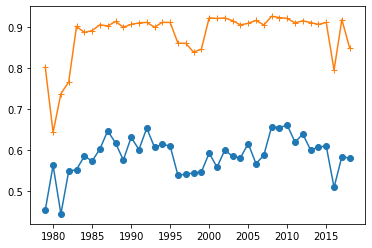

In [61]:
# Yo entiendo que el resultado relevante es el macro, porque considera el desbalance de clases
import matplotlib.pyplot as plt
plt.plot(range(1979,2019), macro, marker='o')
plt.plot(range(1979,2019), weighted, marker='+')

In [62]:
# LASOO por legislatura
macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')
legislaturas=['I', 'II', 'III', 'IV', 'V', 'VI', 'VII','VIII', 'IX', 'X', 'XI', 'XII','XIII']

for x in legislaturas: 
  try: 
    base_year=base[base.legislatura==x]
    X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
    train_matrix = vec.fit_transform(X_train['tokens'])
    test_matrix = vec.transform(X_test['tokens'])  
    lr.fit(train_matrix,y_train)
    predictions = lr.predict(test_matrix )
    macro.append(f1_score(predictions,y_test, average='macro'))
    weighted.append(f1_score(predictions,y_test, average='weighted'))
  except: 
    macro.append(np.nan)
    weighted.append(np.nan)

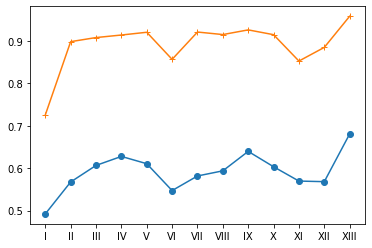

In [63]:
# Yo entiendo que el resultado relevante es el macro, porque considera el desbalance de clases
import matplotlib.pyplot as plt
plt.plot(legislaturas, macro, marker='o')
plt.plot(legislaturas, weighted, marker='+')

In [97]:
# Relevancia de bigramas en la predicción por año
for x in range (1979, 2020): 
  base_year=base[pd.DatetimeIndex(base.fecha).year==x]
  X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
  train_matrix = vec.fit_transform(X_train['tokens'])
  test_matrix = vec.transform(X_test['tokens'])
  lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')
  lr.fit(train_matrix,y_train)
  predictions = lr.predict(test_matrix )
  features=[]
  for i,v in enumerate(lr.coef_[0]):
    features.append([vec.get_feature_names_out()[i],v ])
  sor=sorted(features, key = lambda x: x[1])
  print(f"Año: {x}")
  print(sor[:5])
  print(sor[-5:])

Año: 1979
[['publicada boletín', -2.4014092397624025], ['precedido uso', -1.3877652315007014], ['economía mercado', -1.368743669716857], ['coalición democrática', -1.1137081976910643], ['derecho huelga', -0.9212623017273052]]
[['convenio colectivo', 1.1671273523081962], ['ministerio interior', 1.2020891331698724], ['sector eléctrico', 1.295579410326265], ['formacion política', 1.3089210483762828], ['director gener', 1.330368898395301]]
Año: 1980
[['aprobado artículo', -2.8306572378052026], ['pérez royo', -2.3055710926962556], ['artículo pausa', -2.0542056995009594], ['senado artículo', -2.007267628933476], ['número socialista', -1.5494447716828346]]
[['plan urgencia', 1.3619121009176105], ['unión centro', 1.3672023231835395], ['justicia militar', 1.3935027789433985], ['formación profesion', 1.516075528657475], ['seguridad jurídica', 1.858434335104462]]
Año: 1981
[['santa sede', -1.9494441316825946], ['quiero dejar', -1.0255288691540982], ['derecho comparado', -0.9889046119629769], ['po

# Regresión lineal

In [64]:
X_train, X_test, y_train, y_test = train_test_split(base.loc[:, base.columns != 'party'], base['party'], test_size=0.33, random_state=42)

In [65]:
vec = cv.fit(X_train['tokens'])

In [66]:
train_matrix = vec.fit_transform(X_train['tokens'])
test_matrix = vec.transform(X_test['tokens'])

In [67]:
y_train.replace(['PSOE', 'PP'],[1, -1], inplace=True)
y_test.replace(['PSOE', 'PP'],[1, -1], inplace=True)

In [68]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [69]:
lr.fit(train_matrix,y_train)

LinearRegression()

In [70]:
predictions = lr.predict(test_matrix)

In [71]:
print(lr.coef_)

[ 1.38768308e-02 -4.39994256e-02  3.56696247e-02 -8.29825508e-03
  1.57151298e-03 -7.85540491e-03 -3.23142645e-03 -4.40968595e-02
  2.14397479e-02  5.74665507e-02 -1.63184990e-02 -1.71336802e-02
  1.02833375e-01 -5.80723141e-03 -4.02914875e-02 -1.05560105e-04
 -8.30037164e-03 -1.09689607e-02  3.71741742e-02  3.41639061e-01
 -4.34374509e-02 -1.53689475e-01  3.04306431e-01  4.25574623e-02
  5.03749011e-03  2.06173310e-02 -3.03322363e-03  1.95382159e-03
 -2.09326231e-01  3.65867682e-03 -4.97124573e-02 -4.25538536e-01
 -2.32619423e-02 -1.50333955e-02  1.86045828e-03 -4.34666241e-02
 -3.90259776e-02 -4.74963011e-02 -8.09511793e-02 -5.67225205e-03
  5.76872399e-03 -1.41923235e-01  2.35927774e-03 -3.25742086e-02
 -2.62342492e-02 -3.86139617e-02  6.44498190e-02  6.27149525e-03
  1.12319250e-01  2.74908638e-03  3.16282231e-03 -2.69087887e-03
  1.95166730e-04 -1.27770007e-01  9.41115214e-03 -4.50776301e-02
  2.73850819e-01 -2.84312872e-02 -2.42699970e-01  1.35537392e-02
 -3.85995950e-02  2.16723

In [72]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [73]:
regression_results(y_test,predictions)

explained_variance:  0.0537
r2:  0.0537
MAE:  0.9339
MSE:  0.9307
RMSE:  0.9647


In [74]:
# Relevancia de bigramas en la predicción
features=[]
for i,v in enumerate(lr.coef_):
  features.append([vec.get_feature_names_out()[i],v ])

In [75]:
sorted(features, key = lambda x: x[1])

[['número formula', -1.0656903510044415],
 ['izquierda plural', -0.7152333335625045],
 ['feder izquierda', -0.6543302055763213],
 ['nombr popular', -0.621382843785031],
 ['congreso formula', -0.4255385364292636],
 ['portavoz socialista', -0.40641586761526366],
 ['vaya concluyendo', -0.33127513006740095],
 ['interpelación urgent', -0.2967669989986075],
 ['diputada doña', -0.2426999704636011],
 ['comunidad económica', -0.20932623090924984],
 ['fijación posicion', -0.15949362051134258],
 ['coalición canaria', -0.153689474701157],
 ['rodríguez zapatero', -0.153618541653032],
 ['creación empleo', -0.14192323489373368],
 ['desean fijar', -0.1277700074832435],
 ['ministerio economía', -0.11222840156271131],
 ['servicio social', -0.09257688459177937],
 ['si quier', -0.08628574624652137],
 ['seguridad jurídica', -0.08480773595711359],
 ['sociedad española', -0.08275072970473989],
 ['pueblo español', -0.08201022517100749],
 ['convergència unió', -0.08095117934714666],
 ['déficit público', -0.072

# LDA

In [76]:
from sklearn.decomposition import LatentDirichletAllocation

In [78]:
vec = cv.fit(base['tokens'])

In [79]:
matrix = vec.transform(base['tokens'])

In [90]:
lda = LatentDirichletAllocation(n_components=40, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

In [91]:
lda.fit(matrix)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=40, random_state=0)

In [95]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx + 1))
        print(" , ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [96]:
display_topics(lda, feature_names=cv.get_feature_names_out(), no_top_words=20)

Topic 1:
extraordinaria comisión , seguridad social , convocatoria extraordinaria , poder judici , mayor cincuenta , ahora mismo , zona afectada , salida reino , campo gibraltar , medida urgent , estatuto gernika , transición energética , comú podemgalicia , transición ecológica , presupuesto general , nacion unida , permanent pertenecient , comú podemen , diputada doña , pesca alimentación
Topic 2:
toda medida , fuerza cuerpo , tribun supremo , espinosa montero , estabilidad presupuestaria , trabajador trabajadora , salida reino , convocatoria extraordinaria , estatuto gernika , ahora mismo , seguridad social , medida urgent , zona afectada , transición energética , poder judici , mayor cincuenta , campo gibraltar , hecho referencia , crecimiento económico , si quier
Topic 3:
consejo europeo , hombr mujer , pasamo ahora , zona afectada , convocatoria extraordinaria , seguridad social , salida reino , medida urgent , estatuto gernika , ahora mismo , poder judici , transición energética

In [105]:
# LDA genera una matríz en la que asigna a cada uno de los 200 bigramas una probabilidad de ocurrencia para cada uno de los 40 topics
lda.components_.shape

(40, 200)

# NNMF

In [110]:
from sklearn.decomposition import NMF

In [111]:
nmf = NMF(n_components=40, random_state=1).fit(matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [112]:
display_topics(nmf, feature_names=cv.get_feature_names_out(),  no_top_words=20)

Topic 1:
comunidad madrid , unido podemo , toda españa , formación profesion , acuerd convocatoria , posicion mixto , acuerdo retirada , suficient miembro , estatuto gernika , política española , convocatoria extraordinaria , presentar nombr , gasto público , relacion cort , tribun supremo , resolv problema , marco financiero , buena tard , mercado labor , comú podemgalicia
Topic 2:
vasco legarda , comisión europea , salvamento marítimo , encima mesa , pleno cámara , derecho libertad , comparecencia ministra , igualdad oportunidad , cuerpo seguridad , rodríguez hernández , crisi económica , tribun constitucion , presupuesto general , adoptar medida , tribun supremo , relacion cort , podemgalicia común , hombr mujer , resolv problema , estatuto autonomía
Topic 3:
sistema público , pesca alimentación , quiero decirl , política migratoria , suficient miembro , presentar nombr , legarda uriart , ministra hacienda , crecimiento económico , salida reino , llegar acuerdo , proyecto procedimie

# Guardar la base

In [106]:
base.to_csv('/content/drive/MyDrive/base_formateada.csv')